# Representational Similarity Analysis of the Inferior Temporal Cortex when Looking at Different Visual Stimuli

## Introduction
This notebook takes a look at how our brain categorizes and responds to visual stimuli. The 
fMRI data being used comes from Kriegeskorte et al. (2008), who studied how humans' and monkeys' inferior temporal cortices activate when being presented with images of real world objects.

How do neural patterns compare when humans are looking at an orange vs an orange ping pong ball vs a red apple? In short, the goal of this notebook is to measure the similarity between neural representations while trying to determine which attributes are driving this similarity. 

Representational similarity analysis (RSA) is a way to compare and contrast different brain states and the stimuli that elicited them. In RSA, we compute a similarity measure (often a correlation) between patterns of neural activity for all items being compared. Then, to examine whether neural patterns in a brain region are grouped by color, shape, or category, we can order the similarity measure based on a model that groups by these attributes.

RSA is a highly versatile tool: it can be used to compare data across brain imaging techniques, to compare brain activity to models, and even to make cross-species comparisons. 

## Goal of this Script

1. Perform RSA on a dataset
* Calculate and plot Pearson and Spearman correlations in ROIs  
* Order these similarity matrices in a meaningful way  
* Interpret a (dis)similarity matrix  
2. Visualize similarity with multi dimensional scaling (MDS)

## Table of Contents  
* [1. Prepare for RSA](#preprocessing)
    * [1.1 Load the Data for One Subject](#load_data)  
    * [1.2 Helper Functions ](#helper)  
    * [1.3 Visualize the data](#visualize_data)  


* [2. Create a Similarity Matrix](#sim_mat)  
    * [2.1 Reorder Data into Categories](#reorder)  
    * [2.2 How to Read a Similarity Matrix](#read_sim_mat)  
    * [2.3 Representational Dissimilarity](#read_dsim_mat)  
    * [2.4 Comparison of Representations in Monkeys and Humans](#rdm-monkey-human)  


* [3. Manifolds and Multi-Dimensional Scaling (MDS)](#mds) 
    * [3.1 Plotting RDM in 2d](#plot_2d)  
    * [3.2 Plotting RDM in 3d](#plot_3d)
    
    
* [3D Extension](#3d_extension)
* [Conclusion](#conclusion)
* [Contributions](#contributions)

### Dataset <a id="preprocessing"></a> 

The dataset we will be using for this exercise is from [Kriegeskorte et al. (2008)](https://www.sciencedirect.com/science/article/pii/S0896627308009434), called 'Ninetysix' in the `datasets` folder. 96 visual stimuli, from the 6 categories listed below, were presented to participants. The image stimuli are stored in the subfolder `Stimuli`.

The data have 6 categories:  
    1. artificial inanimate (object/scene)
    2. human bodypart 
    3. human face 
    4. natural inanimate (object/scene)
    5. nonhuman bodypart
    6. nonhuman face

In [98]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


## 1. Prepare for RSA <a id="preprocessing"></a>

### 1.1 Load the Data for One Subject<a id="load_data"></a>

The data for these participants are stored as a matlab file. Python is able to load matlab files using a scipy utility. 

The data from matlab are stored as a dictionary where the variables in the matlab files are keys in the dictionary:

>The ROI names are listed in **roinames**.   
>The category label indices for each condition are listed in **labels**.   
>The label indices correspond to entries in **categoryNames**.  
>The data for each ROI, in the order of roinames, is stored in **roi_data**.  

Each row of roi_data represents a stimulus (as defined in labels) and each column represents a voxel (there will be different numbers of voxels in different ROIs). These data have been preprocessed and each entry is stored in terms of t-values. There is no time information and no baseline signal to be used for reference.

The last 4 rows of the dataset have unknown labels. We'll use only the first 92 rows for analysis, for now and examine the unknown data later.

### 1.2 Helper Functions <a id="helper"> </a>

Helper functions that extract data from matlab files and convert into numpy arrays.

In [99]:
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

In [100]:
# Load the data for one subject
subj_initials = 'BE'
data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

### 1.3 Visualize the Data <a id="visualize_data"></a>

Text(0, 0.5, 'Category')

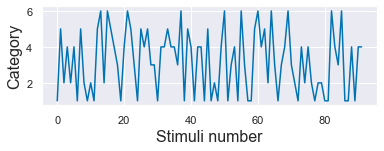

In [101]:
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels)
plt.xlabel('Stimuli number', fontsize=16)
plt.ylabel('Category', fontsize=16)

<div class="alert alert-block alert-warning">
The category order is random i.e. the stimuli at every point are from a different category compared to the neighbors.
</div>

## 2. Create a Similarity Matrix <a id="sim_mat"></a>

Let's examine the similarity of the neural representations of each image with the neural patterns of every other image in the dataset. If the neural patterns are similar between images, we will see high values of similarity, but if the neural patterns are dissimilar, we will see low values of similarity. 

There are many ways to compute similarity. 
Start with: Pearson correlation. We compute the Pearson correlation on the neural pattern for each image with every other image. We can compute this on data for each of the ROIs that we have just loaded (left and right FFA, and left and right PPA). For each ROI, our computation will result in a 92 x 92 matrix (labels for 92 images). 

This resulting matrix shows how similar the neural patterns of activity are between images and is called the representational **similarity** matrix (RSM).

In [102]:
print('ROI names: ', roi_names)

ROI names:  ['lFFA', 'rFFA', 'lPPA', 'rPPA']


Text(0, 0.5, 'stimuli id')

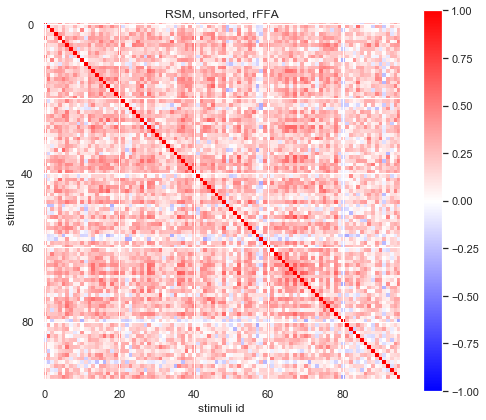

In [103]:
roi_id = 1 #right Fusiform Face Area

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    np.corrcoef(roi_data[roi_id]), 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s' % (roi_names[roi_id])) 
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')

Redo the analysis above with Spearman correlation then visualize the RSM based on Spearman correlation. 

Text(0, 0.5, 'stimuli id')

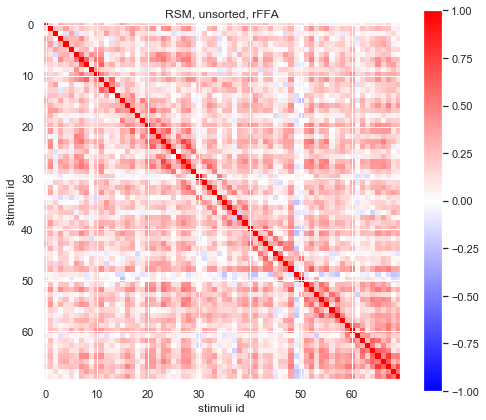

In [104]:
from scipy import stats

roi_id = 1

corr, _ = stats.spearmanr(roi_data[roi_id])

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    corr, 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s' % (roi_names[roi_id])) 
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')


**Explanation:** Since the stimuli are unordered the Pearson correlation shows a more logical matrix. The Spearman correlation matrix might show similarity between certain randomly ordered neighbor stimuli, which is possible but unknown without further analysis.

Different correlation matrices can be visualized with different ROIs.


### 2.1 Reorder Data into Categories <a id="reorder"></a>

To simplify, let's reorganize into label groups so we can see some structure to the matrices.

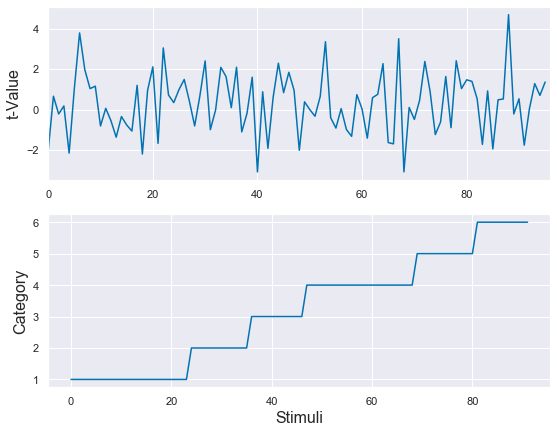

In [105]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
sort_ids = labels.argsort()
lffa_sorted = roi_data[0][sort_ids, :]

plt.figure(figsize=(9,7))

# Plot the new sorted results
plt.subplot(2,1,1)
plt.plot(lffa_sorted[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(labels[sort_ids])
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()

Text(0.5, 1.0, 'RSM, sorted, rFFA')

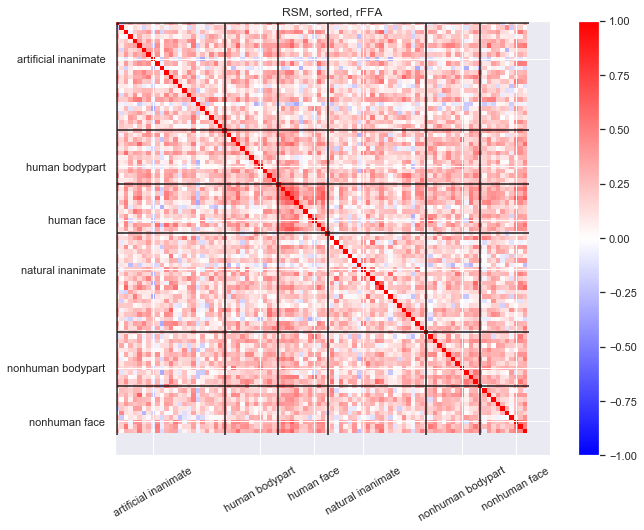

In [106]:
# can change ROI here
roi_id = 1

# Calculate  RSM
rsm = np.corrcoef(roi_data[roi_id][sort_ids, :][:92,])

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rsm, 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(categories)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RSM, sorted, %s' % roi_names[roi_id])

<div class="alert alert-block alert-warning">
<strong>Binning the data:</strong> In Figure 1 of Kriegeskorte et al. (2008), the raw correlation values were binned into ten bins based on the percentile score of the dissimilarity value, and the percentile value was plotted. We have created a function `digitize_rdm` to perform the same calculation here and make the plots similar to Figure 1 in Kriegeskorte et al. (2008). 
<br>    
<br>
Note that Figure 1 was using dissimilarity rather than similarity and that the data were from a different ROI (inferior temporal cortex, or IT). However, we can apply the same function to our RSM, the only difference being that the percentile will be based on similarity. 
<br>    
<br>
The `digitize_rdm` functions works in the following manner:  
<br>    
<br>
1. Create `n_bins` of percentile values.  <br>
2. Take in the matrix of correlations and reshape it into a single row. <br> 
3. Determine the percentile value of every correlation point and assign it to a bin (`np.digitize` does this).  <br>
4. Reshape the assigned percentile values into the original correlation matrix shape.  <br>
5. Finally, plot the percentile values.<br>
<br>
</div>

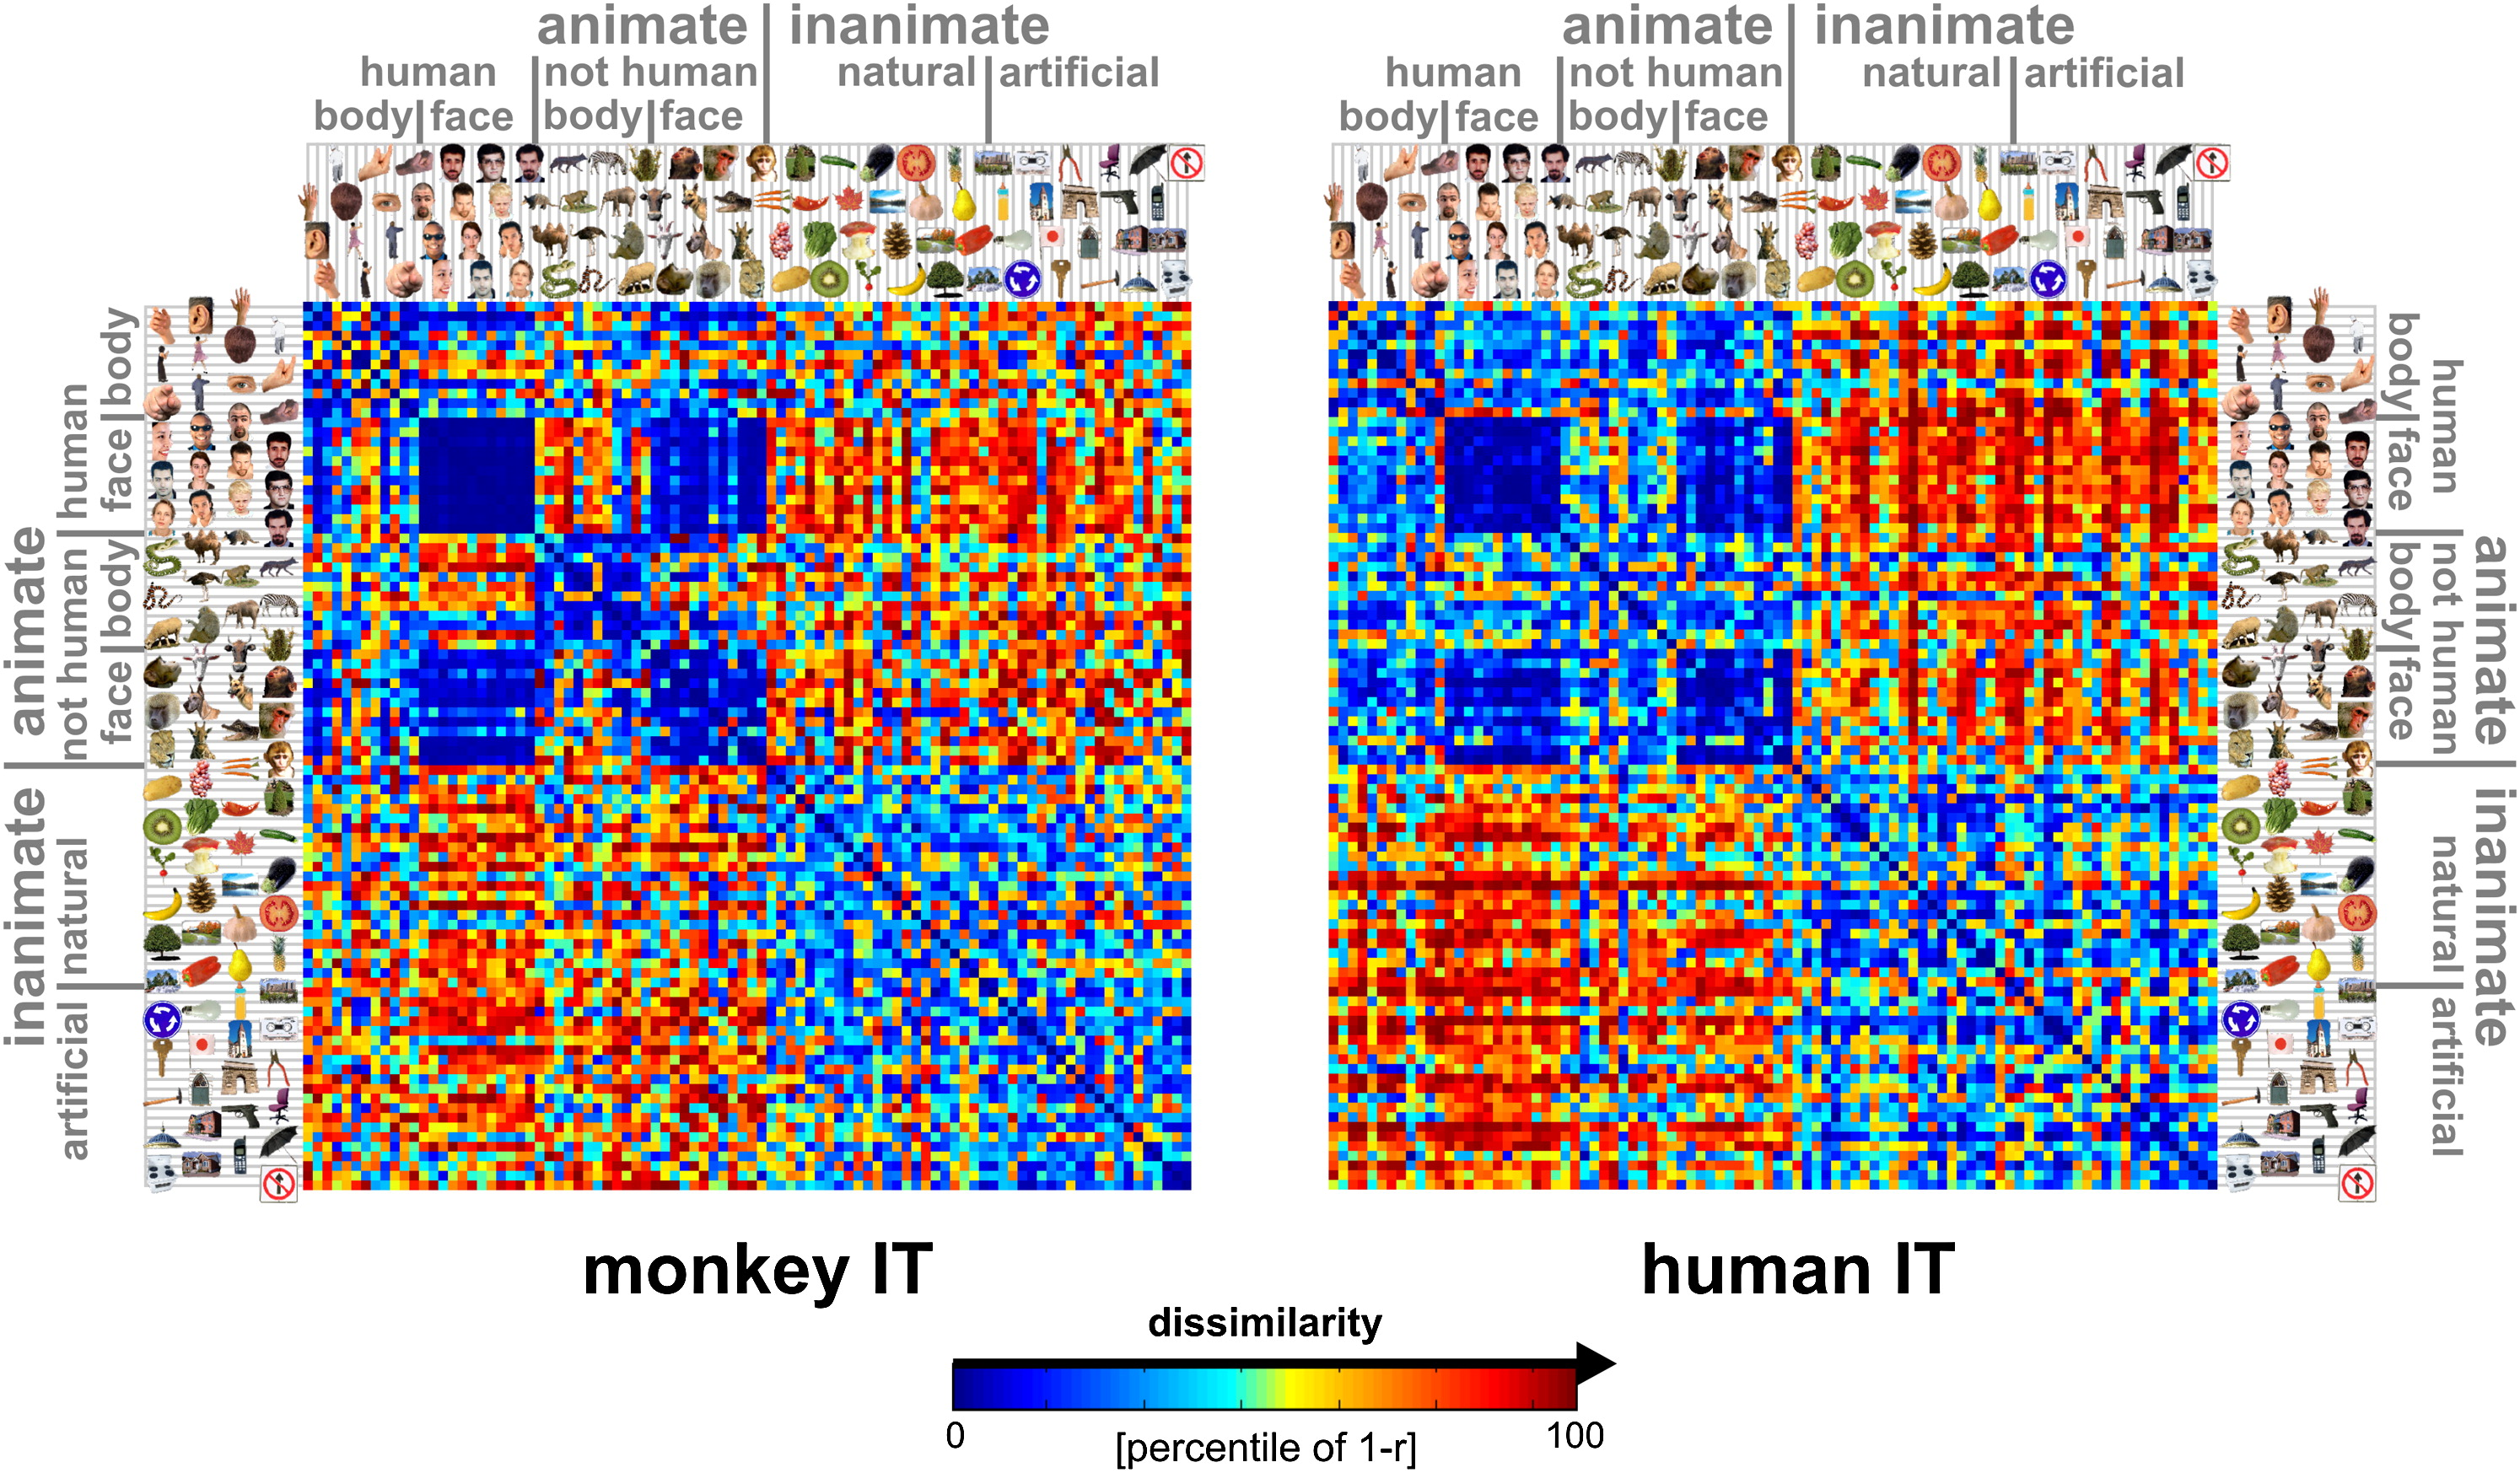

In [107]:
from IPython.display import Image
Image(filename='DSM_IC.jpg') 

### Plot the Representational Similarity Matrix

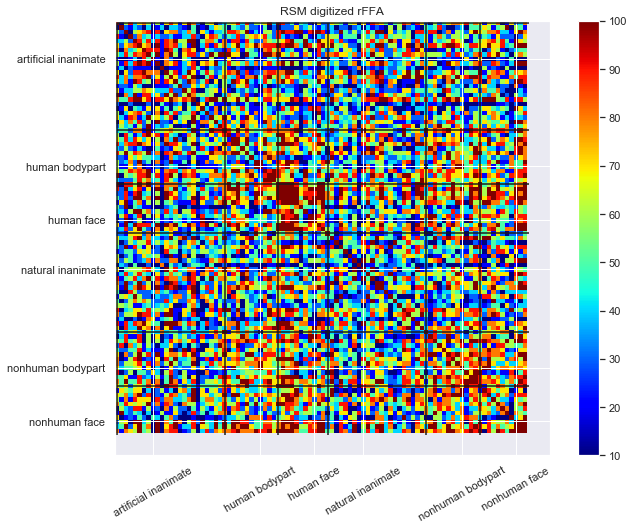

In [108]:
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rsm), cmap='jet', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(categories)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RSM digitized %s' % roi_names[roi_id]);
    

This new organization is helpful but could be improved (based on our knowledge of the brain). Reordering the data points might help make a more conclusive matrix: human face, human body part, non-human face, non-human body part, natural inanimate and artificial inanimate. 


(92, 70)


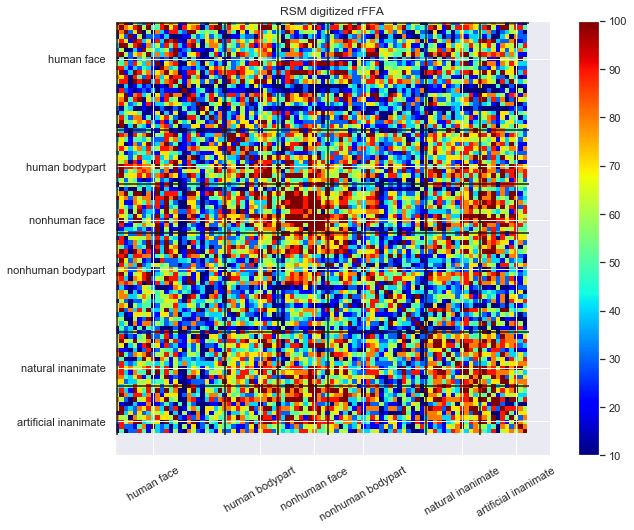

In [109]:
def labeled_arr(label, labels, data):
    arr = []
    for l in range(len(labels)):
        if labels[l] == label:
            arr.append(data[l])
    arr = np.asarray(arr)
    return arr

#(3, 2, 6, 5, 4, 1)
one = labeled_arr(1, labels, roi_data[1])
two = labeled_arr(2, labels, roi_data[1])
three = labeled_arr(3, labels, roi_data[1])
four = labeled_arr(4, labels, roi_data[1])
five = labeled_arr(5, labels, roi_data[1])
six = labeled_arr(6, labels, roi_data[1])

ordered_arr = []
ordered_arr = np.concatenate((one, two, three, four, five, six))
print(ordered_arr.shape)
#2. recompute RSM 
rsm = np.corrcoef(ordered_arr)

#3. visualize RSM 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rsm), cmap='jet', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
categories1 = ['human face','human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate']
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(categories1, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(categories1)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RSM digitized %s' % roi_names[roi_id]);



**Explanation:** In the above plot there is some clear correlation along the diagonal with different levels of similarity scattered throughout. The obvious... items within a category are more similar to one another than they are to items in different categories. That being said there are a lot of variable correlations throughout. 

### 2.3 Representational Dissimilarity <a id="read_dsim_mat"></a>

The previous analyses framed everything in terms of similarity between the items. However people sometimes prefer to consider this type of data in terms of dissimilarity. This close cousin of the similarity matrix is called the representational dissimilarity matrix (RDM). The dissimilarity matrix is computed simply as 1 - correlation. 

Plot the RDM for the right FFA ROI using the new order.

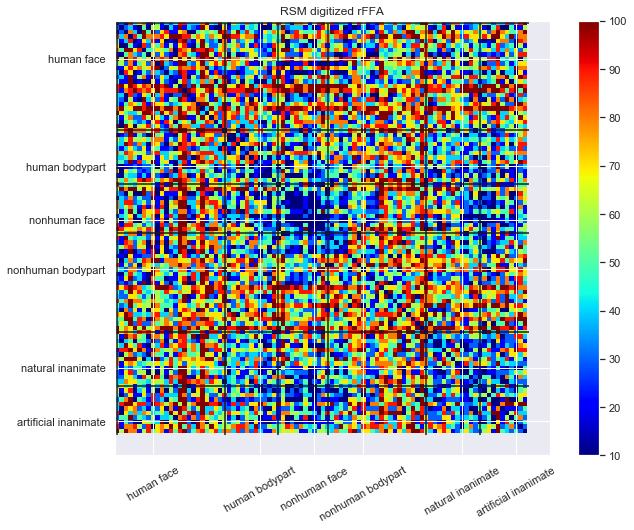

In [110]:
#2. recompute RSM 
rsm = 1 - np.corrcoef(ordered_arr)

#3. visualize RSM 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rsm), cmap='jet', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
categories1 = ['human face','human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate']
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(categories1, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(categories1)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RSM digitized %s' % roi_names[roi_id]);

### 2.4 Comparison of Representations in Monkeys and Humans <a id="rdm-monkey-human"></a>

The RSA can be used to compare information not just in humans, but across species too. Below is comparison of the RDM for monkeys and humans, in the inferior temporal cortex (Color map altered to match Figure 1 in Kriegeskorte et al. (2008)).

Text(0.5, 1.0, 'Human RDM')

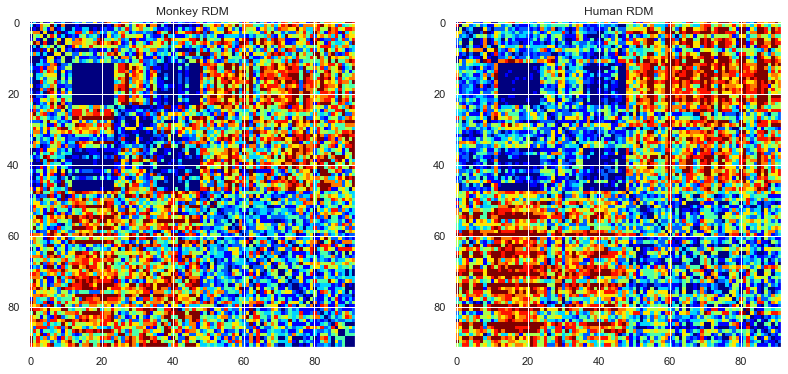

In [111]:
# Load the data, and bin to percentile
monkeyRDM = pd.read_csv(os.path.join(ns_data_dir, 'RDM_mIT_fig1.txt'), header=None)
humanRDM = pd.read_csv(os.path.join(ns_data_dir, 'RDM_hIT_fig1.txt'), header=None)

monkey_rdm_digitized = digitize_rdm(monkeyRDM)
human_rdm_digitized = digitize_rdm(humanRDM)

f, axes = plt.subplots(1,2, figsize = (14, 6))
axes[0].imshow(
    monkey_rdm_digitized, 
    cmap='jet', 
)
axes[1].imshow(
     human_rdm_digitized, 
     cmap='jet', 
)
# plt.colorbar()
axes[0].set_title('Monkey RDM')
axes[1].set_title('Human RDM')


**Explanation:** As can be seen there are areas of high similarity and dissimilarity throughout these matrices and some certain overlap between species even though the stimuli are not ordered in this example. This speaks to the level of how similar low level visual processing in humans and ancestrally similar non-human primates.  

## 3. Manifolds and Multi-Dimensional Scaling (MDS) <a id="mds"></a>

The correlation matrix for the 92 images describes how similarly each item is perceived in comparison to each other item. This means that if two items have a high positive correlation then they can be thought of as eliciting a very similar activation pattern across voxels. We can reframe this to be thought of as a distance in a high-dimensional space. From this perspective, items that are similar to one another will be grouped close together and far away from points that they are dissimilar to. 

MDS allows us to visualize the similarity of our data in a different way than plotting the matrices above. Specifically, it allows to generate a lower-dimensional image (e.g., 2-D or 3-D) in which the distances between points approximate the distances in the original high-dimensional data. There is an MDS [method](https://homepages.uni-tuebingen.de/florian.wickelmaier/pubs/Wickelmaier2003SQRU.pdf) built into [scikit-learn](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

In [112]:
# Create a 2-D MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(digitize_rdm(1 - rsm))  # Use the dissimilarity matrix
# order is unknown

### 3.1 Plot the 2D Structure of the RDM <a id="plot_2d"></a>

We'll plot the 92 images on a "map" signifying how close or far apart images are to each other. We use different colors for the 6 categories of images.

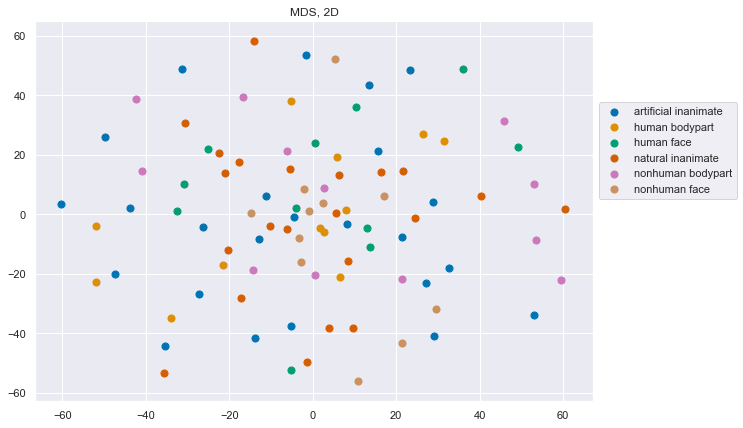

In [113]:
coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');

Now use the similarity matrix here. 

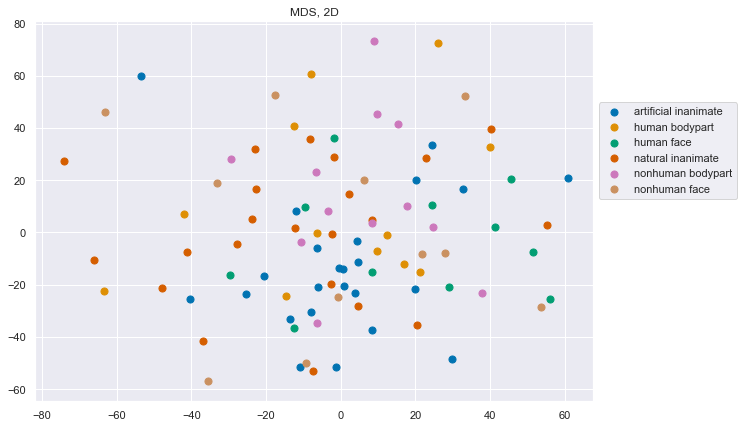

In [114]:
# Create a 2-D MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(digitize_rdm(rsm))  # Use the similarity matrix
# order matters in a scenario like this

coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');


## Image Plot
Each item is plotted as a point. Inspect the images being used and create a plot with them. 

In [115]:
print(label_dict)
print(labels)


{'artificial inanimate': 1, 'human bodypart': 2, 'human face': 3, 'natural inanimate': 4, 'nonhuman bodypart': 5, 'nonhuman face': 6}
[ 1.  5.  2.  4.  2.  4.  1.  5.  2.  1.  2.  1.  5.  6.  2.  6.  5.  4.
  3.  1.  4.  6.  5.  3.  1.  5.  4.  5.  3.  3.  1.  4.  4.  5.  4.  4.
  3.  6.  1.  5.  4.  1.  4.  4.  1.  5.  1.  2.  1.  4.  6.  1.  3.  4.
  1.  6.  3.  1.  1.  5.  6.  4.  5.  2.  6.  3.  1.  3.  4.  6.  3.  2.
  1.  4.  2.  4.  2.  1.  2.  2.  1.  1.  6.  4.  3.  6.  1.  1.  4.  1.
  4.  4. nan nan nan nan]


As can be seen the last 4 items in the list are undefined as 'nan'. Let's do some exploratory analysis to figure out what they are. 

In [116]:
from PIL import Image
import numpy as np

#stored as array images.... no images for 92-96 
img_ex = np.asarray(images[70])
print(img_ex[0].shape)

img = Image.fromarray(img_ex[0], 'RGB')
img.save('my.png')


(175, 175, 3)


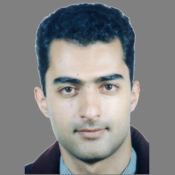

In [117]:
from IPython.display import Image
Image(filename='my.png') 


### 3.2 Plot the 3D Structure of the RDM <a id="plot_3d"></a>

MDS is just trying to find a k-dimensional embedding that minimizes the stress (something akin to the goodness of fit). This means we can actually plot it in arbitrarily high dimensions to try and capture the data structure. Below we make a 3D plot, given that the 2D plot.

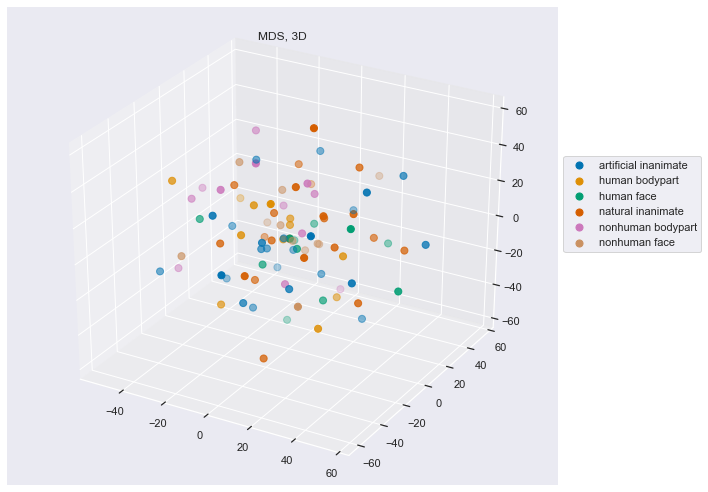

In [118]:
# Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(digitize_rdm(1 - rsm))

coords = results.embedding_

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    ax.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1], coords[label_idxs, 2], 
        marker = 'o', s = 50
    )
    
plt.legend(categories, bbox_to_anchor=(1,.7), loc="upper left")
plt.title('MDS, 3D')
plt.tight_layout()

There are tools available to us to evaluate what is the appropriate dimensionality for visualization of our data (i.e. what dimensionality has sufficiently low stress). We can look at the stress of the MDS with different numbers of components (i.e. different dimensionality) and determine what dimensionality of the data is appropriate.


Text(0.5, 0, 'Dimensionality')

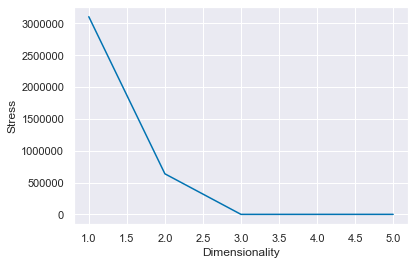

In [119]:
# Calculate the euclidean distance of every point from every other point
dist = sp_distance.squareform(sp_distance.pdist(coords))

# Iterate through different numbers of components
stress = []
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    # Pull out the stress of the MDS fit
    stress.append(mds.fit(dist).stress_)

# Plot the stress
plt.figure(); 
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')

Stress generally decreases with the number of components. Let's perform an analysis to estimate the appropriate dimensionality to visualize the RDM of the right FFA data from this participant. 
Make sure not to calculate the stress metric from the MDS embedding, calculate the MDS fit from the RDM.

MDS documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

Empirically, more stringent convergence criteria (i.e. large `n_init` and `max_iter`, small `eps`) will lead to more stable results. 

Text(0.5, 0, 'Dimensionality')

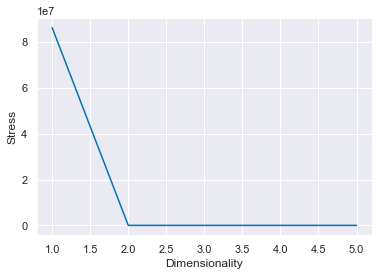

In [120]:
# visualize the RDM of right FFA of participant 1 in a specific dimension 
# RDM of ordered_arr
rsm =  np.corrcoef(ordered_arr)
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(1 - rsm))

coords = results.embedding_

dist = sp_distance.squareform(sp_distance.pdist(coords))

# Iterate through different numbers of components
stress = []
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    # Pull out the stress of the MDS fit
    stress.append(mds.fit(dist).stress_)

# Plot the stress
plt.figure(); 
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')



Compute RDMs and create MDS plots for the left PPA and right PPA using the reordering you created above.

In [121]:
#go through data, create array for data of each label 
def labeled_arr(label, labels, data):
    arr = []
    for l in range(len(labels)):
        if labels[l] == label:
            arr.append(data[l])
    arr = np.asarray(arr)
    return arr

one = labeled_arr(1, labels, roi_data[2])
two = labeled_arr(2, labels, roi_data[2])
three = labeled_arr(3, labels, roi_data[2])
four = labeled_arr(4, labels, roi_data[2])
five = labeled_arr(5, labels, roi_data[2])
six = labeled_arr(6, labels, roi_data[2])


ordered_arrL = []
ordered_arrL = np.concatenate((one, two, three, four, five, six))

one = labeled_arr(1, labels, roi_data[3])
two = labeled_arr(2, labels, roi_data[3])
three = labeled_arr(3, labels, roi_data[3])
four = labeled_arr(4, labels, roi_data[3])
five = labeled_arr(5, labels, roi_data[3])
six = labeled_arr(6, labels, roi_data[3])
ordered_arrR = []
ordered_arrR = np.concatenate((one, two, three, four, five, six))



RDM plotted for leftPPA

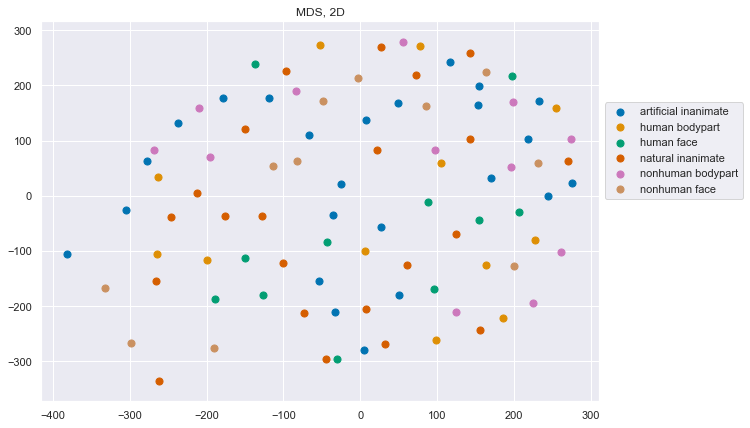

In [122]:
rdm = 1 - np.corrcoef(ordered_arrL)
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(rdm))

coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');
# make a 2D RDA 

RDM plotted for rightPPA

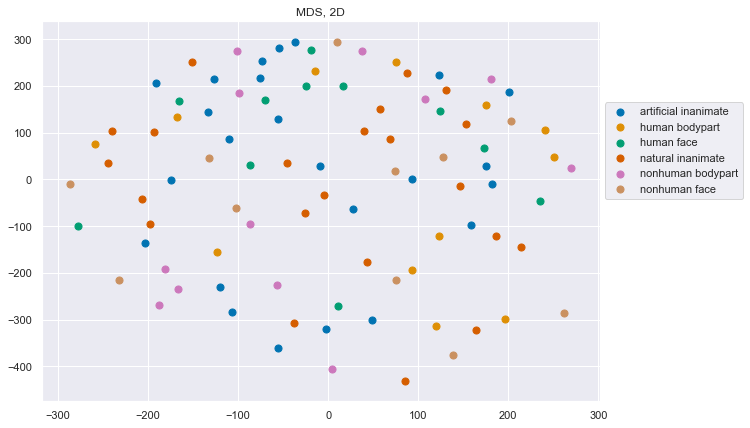

In [123]:
rdm = 1 - np.corrcoef(ordered_arrR)
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(rdm))

coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');

The last four rows in the dataset for subject BE have unmarked labels. One of them is a human face. Using the techniques outlined here and your knowledge of the category preference of each ROI, analyze the data to make a best guess of which one of the 4 missing labels is a human face. 


## Representational Similarity Matrices of All 4 ROIs

### Left Fusiform Face Area Data Ordering for 2D RSM Plot

In [124]:

#go through data, create array for data of each label 
def labeled_arr(label, labels, data):
    arr = []
    for l in range(len(labels)):
        if labels[l] == label:
            arr.append(data[l])
    arr = np.asarray(arr)
    return arr

one = labeled_arr(1, labels, roi_data[0])
two = labeled_arr(2, labels, roi_data[0])
three = labeled_arr(3, labels, roi_data[0])
four = labeled_arr(4, labels, roi_data[0])
five = labeled_arr(5, labels, roi_data[0])
six = labeled_arr(6, labels, roi_data[0])

ordered_arrL = []
ordered_arrL = np.concatenate((one, two, three, four, five, six))

one = labeled_arr(1, labels, roi_data[1])
two = labeled_arr(2, labels, roi_data[1])
three = labeled_arr(3, labels, roi_data[1])
four = labeled_arr(4, labels, roi_data[1])
five = labeled_arr(5, labels, roi_data[1])
six = labeled_arr(6, labels, roi_data[1])
ordered_arrR = []
ordered_arrR = np.concatenate((one, two, three, four, five, six))


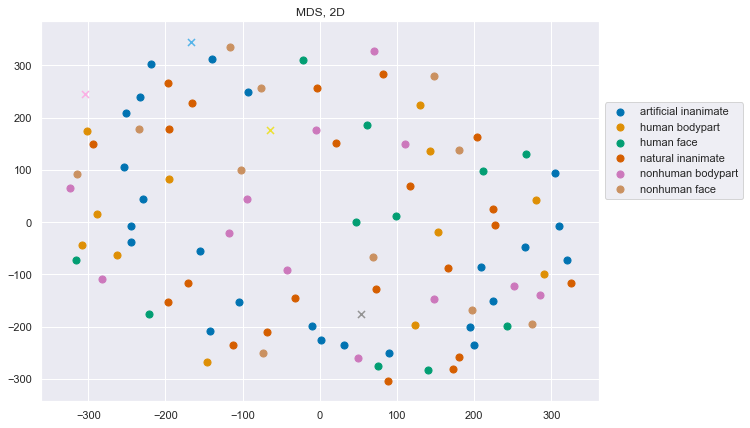

In [125]:
#concatenate onto 
last4l = roi_data[0][92:] #concatenate onto orderedArrL
last4r =  roi_data[1][92:] #cocatenate onto orderedArrR
ordered_arrL_unknown = np.concatenate((ordered_arrL, last4l), axis=0)

#compute RSM 
rsm = np.corrcoef(ordered_arrL_unknown)
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(rsm))
coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:96] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )
    

for i in range(4):
    plt.scatter(
        coords[95 - i, 0], coords[95 - i, 1],
        marker = 'x', s = 50
    )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');


### Right Fusiform Face Area Data Ordering for 2D RSM Plot

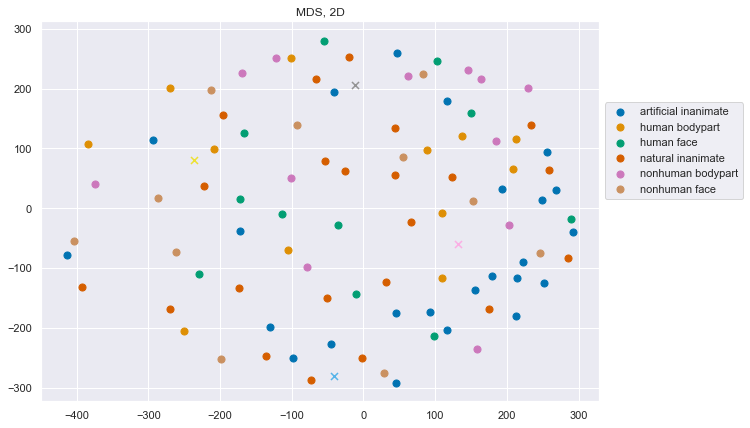

In [126]:
#concatenate onto 
last4l = roi_data[0][92:] #concatenate onto orderedArrL
last4r =  roi_data[1][92:] #cocatenate onto orderedArrR
ordered_arrR_unknown = np.concatenate((ordered_arrR, last4r), axis=0)

#compute RDM 
rsm = np.corrcoef(ordered_arrR_unknown)
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(rsm))
coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:96] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )
    

for i in range(4):
    plt.scatter(
        coords[95 - i, 0], coords[95 - i, 1],
        marker = 'x', s = 50
    )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');

### Left Parahippocampal Place Area Data Ordering for 2D RSM Plot

In [127]:
one = labeled_arr(1, labels, roi_data[2])
two = labeled_arr(2, labels, roi_data[2])
three = labeled_arr(3, labels, roi_data[2])
four = labeled_arr(4, labels, roi_data[2])
five = labeled_arr(5, labels, roi_data[2])
six = labeled_arr(6, labels, roi_data[2])


ordered_arrL = []
ordered_arrL = np.concatenate((one, two, three, four, five, six))

one = labeled_arr(1, labels, roi_data[3])
two = labeled_arr(2, labels, roi_data[3])
three = labeled_arr(3, labels, roi_data[3])
four = labeled_arr(4, labels, roi_data[3])
five = labeled_arr(5, labels, roi_data[3])
six = labeled_arr(6, labels, roi_data[3])
ordered_arrR = []
ordered_arrR = np.concatenate((one, two, three, four, five, six))


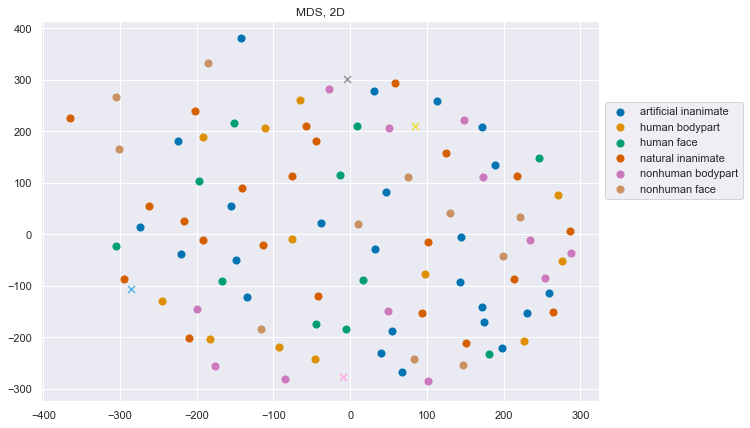

In [128]:
#concatenate onto 
last4l = roi_data[2][92:] #concatenate onto orderedArrL
last4r =  roi_data[3][92:] #cocatenate onto orderedArrR
ordered_arrL_unknown = np.concatenate((ordered_arrL, last4l), axis=0)

#compute RDM 
rsm = np.corrcoef(ordered_arrL_unknown)
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(rsm))
coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:96] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )
    

for i in range(4):
    plt.scatter(
        coords[95 - i, 0], coords[95 - i, 1],
        marker = 'x', s = 50
    )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');

### Right Parahippocampal Place Area Data Ordering for 2D RSM Plot

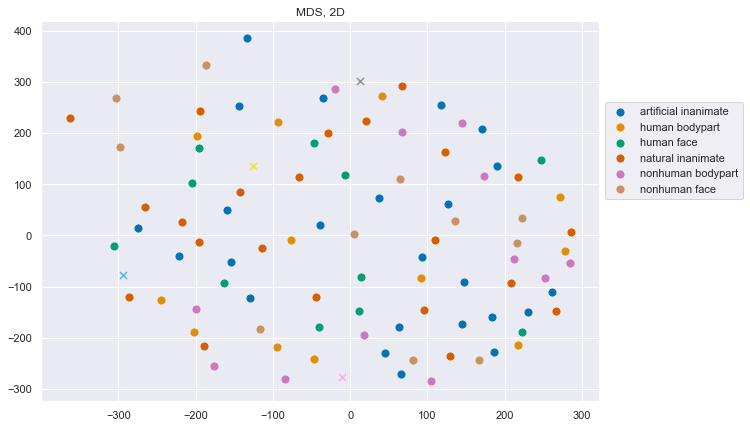

In [129]:
#concatenate onto 
last4l = roi_data[2][92:] #concatenate onto orderedArrL
last4r =  roi_data[3][92:] #cocatenate onto orderedArrR
ordered_arrR_unknown = np.concatenate((ordered_arrR, last4r), axis=0)

#compute RDM 
rdm = 1 - np.corrcoef(ordered_arrL_unknown)
mds = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
results = mds.fit(digitize_rdm(rdm))
coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:96] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1],
        marker = 'o', s = 50
        )
    
for i in range(4):
    plt.scatter(
        coords[95 - i, 0], coords[95 - i, 1],
        marker = 'x', s = 50
    )

plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');

**Results:** Although it can't be validated, in all 4 regions of interest the yellow cross marker was the closest if not second closest to the green dot markers indicating this point is most likely to be representative of the human face image. 

## 3D Extension <a id="3d_extension"></a> 
Multi Dimensional Scaling of similarity and dissimilarity matrices are a little hard to decipher as the results are not that consistent overall. Let's see what we can do by changing the masks and applying PCA. 

In [130]:
from sklearn.model_selection import cross_val_score, cross_validate, PredefinedSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFECV, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


### 2 Component PCA of Right PPA

['lFFA', 'rFFA', 'lPPA', 'rPPA']
{'artificial inanimate': 1, 'human bodypart': 2, 'human face': 3, 'natural inanimate': 4, 'nonhuman bodypart': 5, 'nonhuman face': 6}
(96, 273)
(96, 273)
(96, 2)


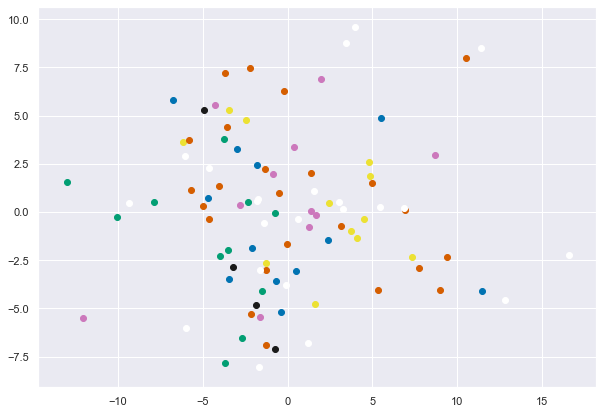

In [132]:
print(roi_names)
print(label_dict)
print(roi_data[3].shape)
#try right PPA 
#preprocess data 

scaler = StandardScaler()
roi_to_pca = scaler.fit_transform(roi_data[3])

pca = PCA(n_components=2)
bold_pca = pca.fit_transform(roi_to_pca)

plt.figure(figsize=(10,7))

def scatter_label2d():
    for i, label in enumerate(labels): 
        if label == 1: #artificial inanimate
            color = 'r'
        elif label == 2: #human bodypart
            color = 'b'
        elif label == 3: #human face
            color = 'g'
        elif label == 4: #natural inanimate
            color = 'w'
        elif label == 5: #nonhuman bodypart
            color = 'y'
        elif label == 6: #nonhuman face
            color = 'm'
        else:
            color = 'k'
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1], color = color)

print(roi_data[3].shape)
print(bold_pca.shape)

scatter_label2d()

#rip a scree plot 

**Explanation:** There is no clear clustering but certainly some general trends for each category. Faces for example are scaled to negative values on the x-axis in 2 dimensions. 

### PCA Scree Plot Analyzing Stress of Components

[0.10310291 0.05879493 0.03705075 0.03176743 0.02636912 0.02507722
 0.02452521 0.02214355 0.02155579 0.02063141 0.02011748 0.01963228
 0.01842039 0.01794929 0.01731506 0.0172831  0.01645798 0.0160749
 0.0154366  0.01510325]
[-4.6284484  -0.37037293  0.73502002  3.28137949 -2.67649543  3.13549173
 -1.34901582  3.250625   -4.18935679  0.49912667 -4.11810637 -1.58627692
 -0.60158829  0.52516509 -0.03948233  1.23205986  2.19548667 -1.49182151
  1.29058636  1.69750608]


Text(0, 0.5, 'Eigenvalue')

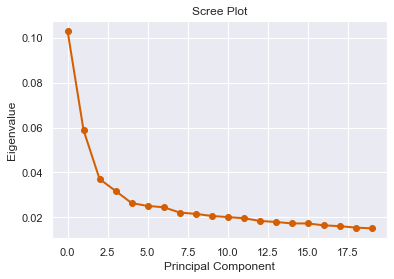

In [133]:
pca = PCA(n_components=20)
bold_pca = pca.fit_transform(roi_to_pca)

var = pca.explained_variance_ratio_ #use var instead of eignevalcount
print(var)

print(bold_pca[19])
plt.plot(np.arange(0, bold_pca.shape[1]), var, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

The scree plot shows us 3 dimensions might do the trick!

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


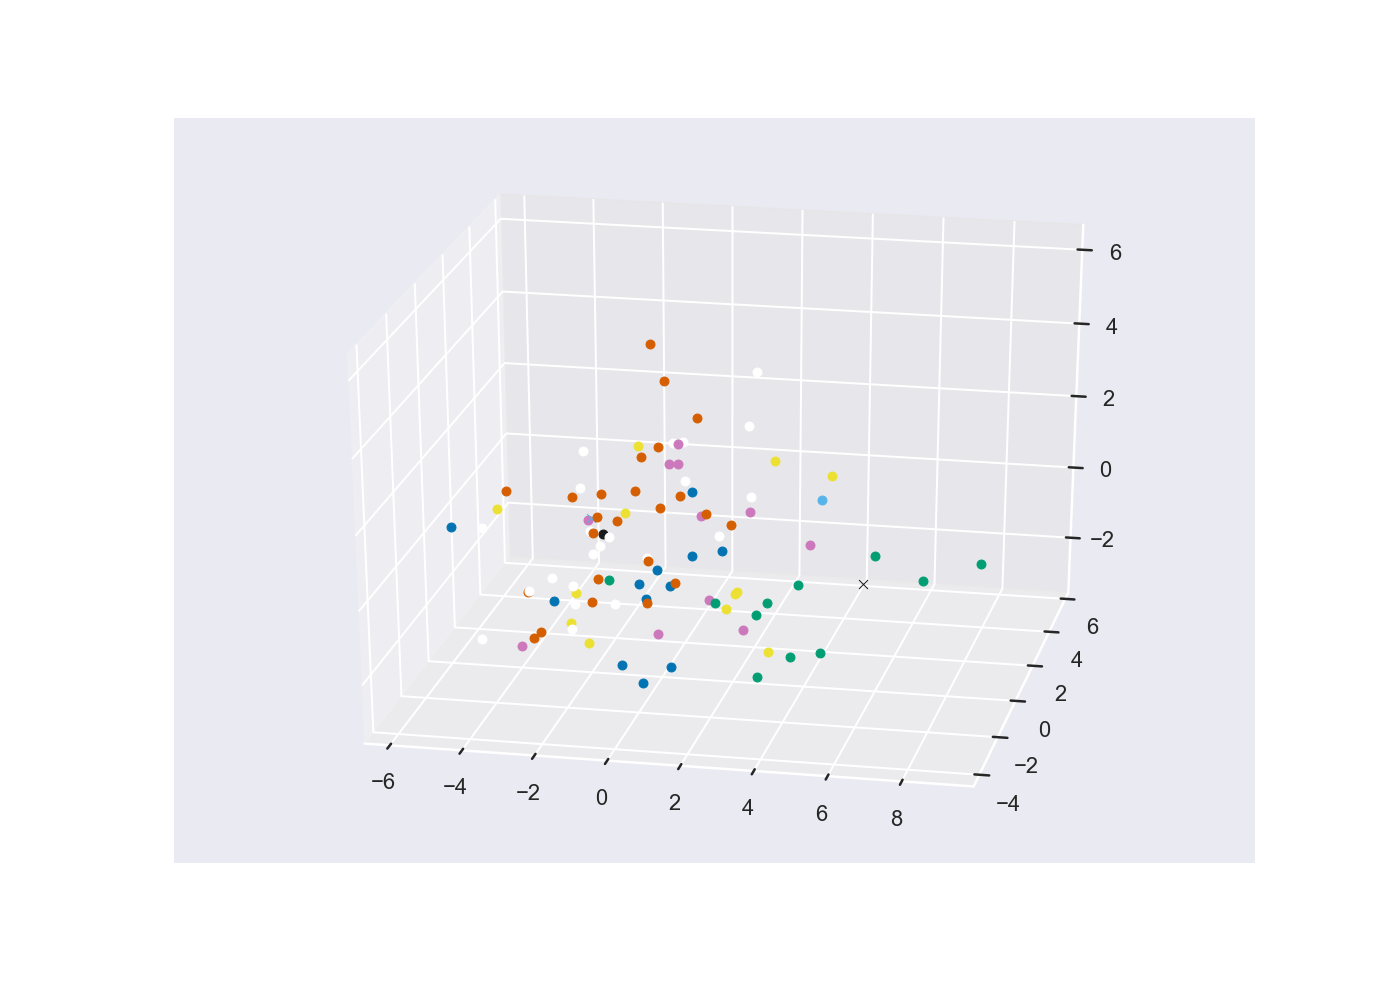

In [140]:
%matplotlib inline  
%matplotlib notebook
%pylab


def scatter_label3d(roi_id):
    scaler = StandardScaler()
    roi_to_pca = scaler.fit_transform(roi_data[roi_id])
    pca = PCA(n_components=3)
    bold_pca = pca.fit_transform(roi_to_pca)
    ax = plt.axes(projection='3d')
    marker = 'o'
    for i, label in enumerate(labels): 
        if label == 1: #artificial inanimate
            color = 'r'
        elif label == 2: #human bodypart
            color = 'b'
        elif label == 3: #human face
            color = 'g'
        elif label == 4: #natural inanimate
            color = 'w'
        elif label == 5: #nonhuman bodypart
            color = 'y'
        elif label == 6: #nonhuman face
            color = 'm'
        else:
            if i == 92:
                color = 'k'
                marker = 'x'
            elif i == 93:
                color = 'k'
                marker = 'o'
            elif i == 94:
                color = 'c'
                marker = 'x'
            elif i == 95:
                color = 'c'
                marker = 'o'
        ax.scatter(bold_pca[i, 0], bold_pca[i, 1], bold_pca[i, 2], marker = marker, c=color, cmap='viridis', linewidth=0.5);

scatter_label3d(0)

In [137]:
scatter_label3d(1)

In [138]:
scatter_label3d(2)

In [139]:
scatter_label3d(3)

## Conclusion <a id="conclusion"></a> 
While this notebook explores important concepts in Multi-Dimensional Scaling and Similarity Matrices, the utility of these concepts is applied in the 3D extension section. As previously explained, the last 4 images in the dataset being used are unlabeled meaning it is unknown what the contents of the picture actually were. The analysis that took place was aimed at finding out which one of those last 4 points represented a human face. 

From utilizing MDS and RSM contingently in 2 dimensions it was predicted that the yellow cross hair is representative of the human face unknown point. Once PCA is fit and plotted in 3 dimensions we see a similar pattern emerge, but now with a black crosshair. 
From analysis of both the 2D and 3D plots it is likely that the yellow and black crosshairs are in fact representative of the same point and in fact do encode an underlying image of a face. 

In both 2 and 3 dimensions it is possible to use dimensional scaling of either raw data or similarity matrices in order to identify what image each unknown point corresponds to. 

If more data points were available clustering algorithms such as k-Nearest Neighbors or Expectation Maximization could yield useful results for classification. 


## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook. 02/2018   
The mystery label exercise was borrowed from a matlab version created by F. Pereira.  
T. Meissner minor edits.  
Q. Lu plot aesthetics, digitization func, modularize funcs, re-ordering, replicate the original paper.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19